# EOF ANALYSIS OF SEA SURFACE TEMPERATURES

<div class="alert alert-block alert-success" style="font-size:16px">In this exercise, you will compute and then plot the first three (3) EOFs of global sea surface temperature (SST) anomalies. There will be options along the way to change your analysis (i.e., keep the trend in vs. detrend the data, choosing different regions, etc). Be sure to read the directions carefully.</div>

<div style="font-size:16px"><b>Make sure to follow the directions written in the document. <font color=green>Green</font> boxes contain important information and have <u>completed</u> code after them. <font color=gold>Yellow</font> boxes contain options for the program that you will select (and can later change). <font color=blue>Blue</font> boxes contain instructions, and the cells after them are for YOU to complete in-class.</b></div>

In [19]:
# Import needed libraries.

import sys,warnings,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from netCDF4 import Dataset,num2date
from mpl_toolkits.basemap import Basemap, cm
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.ticker import MultipleLocator
from scipy import stats

warnings.simplefilter('ignore')

# LOAD THE SST DATA

<div class="alert alert-block alert-success" style="font-size:16px">Load the data globally from 1900-2010.</div>

In [20]:
years = np.array([1900,2010])

ncFile = 'sst.mon.mean.nc'
sst = {}
with Dataset(ncFile,'r') as nc:
    sst['lon'] = nc.variables['lon'][:] - 360.
    sst['lat'] = nc.variables['lat'][:]
    
    # Load in the time variable and only retain data from 1900-2000.
    time = nc.variables['time'][:]
    timeUnits = nc.variables['time'].units
    
    tmp = num2date(time,timeUnits,calendar='standard')
    allDates = np.asarray([datetime(d.year,d.month,15) for d in tmp])
    itime = np.where( (allDates>=datetime(years[0],1,1)) & (allDates<datetime(years[1]+1,1,1)) )[0]
    
    sst['date'] = allDates[itime]
    sst['year'] = np.asarray([d.year for d in sst['date']])
    sst['month'] = np.asarray([d.month for d in sst['date']])
    
    # Read in the data.
    tmp = nc.variables['sst'][itime,:,:] # time x lat x lon
    try: sst['data'] = np.where(tmp.mask,np.nan,tmp.data)
    except: sst['data'] = tmp
    
    # Define a land mask for your data. The mask will be NaN for all land points
    # and 1 for all ocean points.
    
    sst['mask'] = np.where(~np.isnan(sst['data'][0,:,:].squeeze()),1,np.nan)
    sst['units'] = nc.variables['sst'].units

# REMOVE THE SEASONAL CYCLE

<div class="alert alert-block alert-success" style="font-size:16px">Use the provided climatology file to compute the anomalies (i.e., remove the long-term monthly mean from each value).</div>

In [21]:
ltmFile = 'sst.mon.ltm.nc' 
with Dataset(ltmFile,'r') as nc:
    ltm = nc.variables['sst'][:] # 12 x lat x lon - One for each month

sst['ano'] = np.ones_like(sst['data'])*np.nan
for n,imon in enumerate(range(1,13)):
    x = np.where( (sst['month']==imon) )[0]
    sst['ano'][x,:,:] = sst['data'][x,:,:] - ltm[n,:,:]

# CHOOSE YOUR DOMAIN.

<div class="alert alert-block alert-warning" style="font-size:16px">EOFs can change depending on the spatial domain chosen. This becomes important when you are doing your analysis. You want a big enough domain to capture large structures but not too big as to introduce variability from other "outside" areas. Below, choose a region over which to do the EOF analysis. <b>For your FIRST time 
through the exercise, set REGION = 'TROP PAC'.</b></div>


In [22]:
# REGION= 'GLOBAL'
REGION = 'TROP PAC'
#REGION = 'N PAC'
#REGION = 'N ATL'

if REGION == 'GLOBAL':
    ilon = np.arange(sst['lon'].size)
    ilat = np.where( abs(sst['lat'])<=75 )[0]
elif REGION == 'TROP PAC':
    ilon = np.where( (sst['lon']>=-240) & (sst['lon']<=-60) )[0]
    ilat = np.where( abs(sst['lat'])<=30 )[0]
elif REGION == 'N PAC':
    ilon = np.where( (sst['lon']>=-240) & (sst['lon']<=-90) )[0]
    ilat = np.where( (sst['lat']>=15) & (sst['lat']<=70) ) [0]
elif REGION == 'N ATL':
    ilon = np.where( sst['lon']>=-90 )[0]
    ilat = np.where( (sst['lat']>=15) & (sst['lat']<=70) )[0]


# CHOOSE THE TIME PERIOD FOR THE EOF ANALYSIS

<div class="alert alert-block alert-warning" style="font-size:16px">EOFs can change depending on the time of year you are considering. Think about, for example, the different atmospheric patterns you see in the mid-latitudes between summer and winter. Below, choose a time period. <b>For the FIRST TIME through the exercise, choose TIME = 'MONTHLY'.</b></div>


In [23]:
# TIME = 'MONTHLY'
TIME = 'WINTER'

if TIME == 'MONTHLY':
    itime = np.arange(sst['month'].size)
else:
    itime = np.where( (sst['month']>=10) | (sst['month']<=3) )[0]


# PREP THE DATA FOR EOF ANALYSIS

<div class="alert alert-block alert-success" style="font-size:16px">First, truncate the data based on the region to study and the time period.</div>

In [24]:
subset = sst['ano'][itime,:,:][:,ilat,:][:,:,ilon] #Subset of SST data to analyze.
lon = sst['lon'][ilon] # Only keep the longitude points of interest.
lat = sst['lat'][ilat] # Only keep the latitude points of interest.

lon,lat = np.meshgrid(lon,lat)

T,J,I = subset.shape

<div class="alert alert-block alert-warning" style="font-size:16px">Detrend your data at each point (or not). <b>For the FIRST TIME through the exercise</b>, set DETREND = True. In either case, we will name the final result "ssta." This array "ssta" should be dimensioned time x space (use the numpy reshape method for this).

In [28]:
def detrend(y):
    '''
    linear regression to detrend
    
    Args:
    -------------------
    :y - numpy.ndarray; target to detrend
    
    Returns:
    -------------------
    :detrend - numpy.ndarray; 
    '''
    
    t= np.arange(len(y))
    E= np.ones((t.size,2))*np.nan
    E[:,0] = t
    E[:,1] = 1
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
    trend = E.dot(xhat)
    detrend= y- trend
    
    return detrend, xhat, trend

In [29]:
DETREND = True
# DETREND = False

if DETREND is True:
    ssta, _, trend = detrend(subset.reshape((T,-1), order='F')) # Detrend the data. You can use previous code you wrote for this.
else:
    ssta = subset.reshape((T,-1), order='F')

In [36]:
trend[0]

array([        nan,         nan, -0.97466155, ...,         nan,
               nan,         nan])

<div class="alert alert-block alert-info" style="font-size:16px">Weight (i.e., multiply) the data points by the square root of the cosine of latitude. This is the matrix that will be used for the eigenanalysis.</div>

In [27]:
ssta= ssta.reshape((T, I, J), order='F')
weights = np.cos(np.deg2rad(lat[:,0]))**.5
weightedSSTa = ssta*weights

In [39]:
weightedSSTa[0]

masked_array(data=[       nan,        nan,        nan, ...,  0.0365604,
                   -0.0969187,        nan],
             mask=False,
       fill_value=1e+20)

In [48]:
weightedSSTa

masked_array(
  data=[[        nan,         nan, -0.26790185, ...,         nan,
                 nan,         nan],
        [        nan,         nan,  0.77902243, ...,         nan,
                 nan,         nan],
        [        nan,         nan, -0.06153819, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan, -0.40550174, ...,         nan,
                 nan,         nan],
        [        nan,         nan, -0.74073927, ...,         nan,
                 nan,         nan],
        [        nan,         nan,  0.2455603 , ...,         nan,
                 nan,         nan]],
  mask=False,
  fill_value=1e+20)

In [49]:
A

masked_array(
  data=[[-0.26790185, -0.31581019, -0.28290665, ...,  1.06399968,
          1.14851781,  1.23279426],
        [ 0.77902243,  0.97517104,  1.13814843, ...,  0.73157338,
          0.79268748,  0.86019793],
        [-0.06153819, -0.11242919, -0.17009781, ...,  0.14756206,
          0.27277905,  0.40384524],
        ...,
        [-0.40550174, -0.23002752, -0.00748097, ...,  0.59436423,
          0.67512962,  0.72799358],
        [-0.74073927, -0.45886374, -0.15120732, ...,  0.55466184,
          0.64215717,  0.70363923],
        [ 0.2455603 ,  0.48789763,  0.78727292, ...,  0.3420064 ,
          0.37484017,  0.39597195]],
  mask=False,
  fill_value=1e+20)

<div class="alert alert-block alert-info" style="font-size:16px">Next, SSTs are undefined over land (i.e., NaN in the space domain of the array). Remove the NaNs from weightedSSTa and set up a new 2-D array with no NaN values. Call this new matrix $A$.</div>

In [41]:
ssta= ssta= ssta.reshape((T, I, J), order='F')
weights = np.cos(np.deg2rad(lat[:,0]))**.5
weightedSSTa = (ssta*weights).transpose(0,2,1).reshape(T,-1, order='F')
_, cols= np.where(np.isnan(weightedSSTa))

A = np.delete(weightedSSTa, cols, axis=1)

# CONDUCT THE EOF ANALYSIS

<div class="alert alert-block alert-warning" style="font-size:16px">As discussed in class, there are two ways you can do this. <b>For the FIRST TIME through the exercise</b>, choose the SVD Method (i.e., <b>METHOD #2</b>). Afterwards, I encourage you to go back and perform the analysis using <b>METHOD #1</b>.</div>

<div class="alert alert-block alert-info" style="font-size:16px"><b><u>METHOD #1:</u> Eigenanalyze the covariance matrix C.</b>

You will construct the covariance matrix $A^TA$ for eigenanalysis.</div>

C = 
print(C.shape)

# Now pass the covariance matrix into the eig routine (np.linalg.eig).
# Call the output "EOFs" (for the) and "eigval.""
?

<div class="alert alert-block alert-info" style="font-size:16px">If you did the steps as described, your routine will return the spatial patterns (EOFs) and the eigenvalues. Next, back out the time series (i.e., principal component time series). To do this, <u>project</u> (i.e., matrix multiply) each EOF map with the original SST anomalies (ssta). The projection should be weighted by $\cos\varphi$</div>.


mapWeights = np.cos(np.radians(lat))
PCs = ?

<div class="alert alert-block alert-info" style="font-size:16px"><b><u>METHOD #2:</u> Singular Value Decomposition of the Data Matrix.</b> 

You will use np.linalg.svd for this. Remember, the routine returns three matrices. If you send in $A$ as time x space, the columns of $U$ will have the PCs, the diagonal of $\Sigma$ will have the <i>square root</i> of the eigenvalues, and the columns of $V$ will have the EOFs.</div>

In [59]:
U, S, V= np.linalg.svd(A)

PCs = U
eigval = S/A.shape[1] # When using SVD in Python, it already returns the DIAGONAL of Sigma as an output.
                         # Also, you must scale (i.e., divide) squared values of the sigma matrix by
                         # the sample size (i.e., the column size of A; I*J) to get the actual eigenvalues.

# PREP YOUR RESULTS FOR PRESENTATION

<div class="alert alert-block alert-info" style="font-size:16px"><b><u>Step #1:</u></b> Standardize the PC time series.</div>

In [60]:
stdPCs = (PCs- PCs.mean(axis=1))/PCs.std(axis=1)

<div class="alert alert-block alert-info" style="font-size:16px"><b><u>Step #2:</u></b> Regress the <b>ORIGINAL, UNWEIGHTED ANOMALIES</b> (i.e., the variable subset) onto each standardized PC. This will produce SST anomaly MAPS but with the physical units.

In [61]:
regressPatterns = stdPCs.T.dot(ssta.reshape(T,-1,order='F'))/T
# ssta.reshape(T,-1,order='F').T.dot(stdPCs)/T

<div class="alert alert-block alert-info" style="font-size:16px"><b><u>Step #3:</u></b> Calculate the variance explained by each mode. Do this for ALL modes.</div>

In [62]:
varExp = eigval/(eigval).sum()

# PLOT YOUR RESULTS

<div class="alert alert-block alert-info" style="font-size:16px">You are now ready to plot your results. You will make a two-panel plot for each EOF/PC pair. The top panel will be the spatial pattern and the bottom panel will be the standardized PC time series. In the title of the spatial pattern plot, include the variance explained by that mode.</div>

In [63]:
def visualize(lon, lat, data, stipple=None, **figkwargs):
    """
    Args:
    ---------------
    :figkwargs - dict; {
                        'ylabel': '',
                        'cmap': 'seismic',
                        'cRange': (-1,1),
                        'title': '',
                        'extent': tuple; (llclon, llclat, urclon, urclat)
                        'projection': str; default 'npstere'
                        }
    """
    
    ylabel= figkwargs.get('ylabel', '')
    cmapName= figkwargs.get('cmap', 'seismic')
    cRange= figkwargs.get('cRange', (-1,1))
    title= figkwargs.get('title', '')
    lllon, lllat, urlon, urlat= figkwargs.get('extent', (-180, -90, 180, 90))
    proj= figkwargs.get('projection', 'npstere')
    
    if proj!='npstere':
        rnd= False
    else: rnd=True
    
    
    cmin = cRange[0]; cmax = cRange[1];
    cint = 0.2; clevs = np.round(np.arange(cmin,cmax,cint),1)
    nlevs = len(clevs)-1
    
    plt.gca()
    cmap = plt.get_cmap(name= cmapName,lut=nlevs) 
    m = Basemap(projection='cyl',
            llcrnrlat=-40,urcrnrlat=40,llcrnrlon=-240,urcrnrlon=-60,resolution='l')
    
    x,y = m(lon,lat)
    m.drawcoastlines(linewidth=3)
    m.drawmapboundary(linewidth=2)
#     m.drawmeridians(range(-90, 90, 10))
#     m.drawparallels(range(-360, 0, 20))
    if stipple is not None:
        m.plot(x[stipple], y[stipple],'o',color='Gold',markersize=1.5) #
    cs = m.contourf(x, y, data, cmap=cmap)
    cbar = m.colorbar(cs,size='2%')
    cbar.ax.set_ylabel(ylabel) 
    plt.title(title,name='Arial',weight='bold',size=20)
    
    return m

Text(0.5, 1.0, '42.9% of the variance explained by the leading mode')

Text(0, 0.5, 'Index (std)')

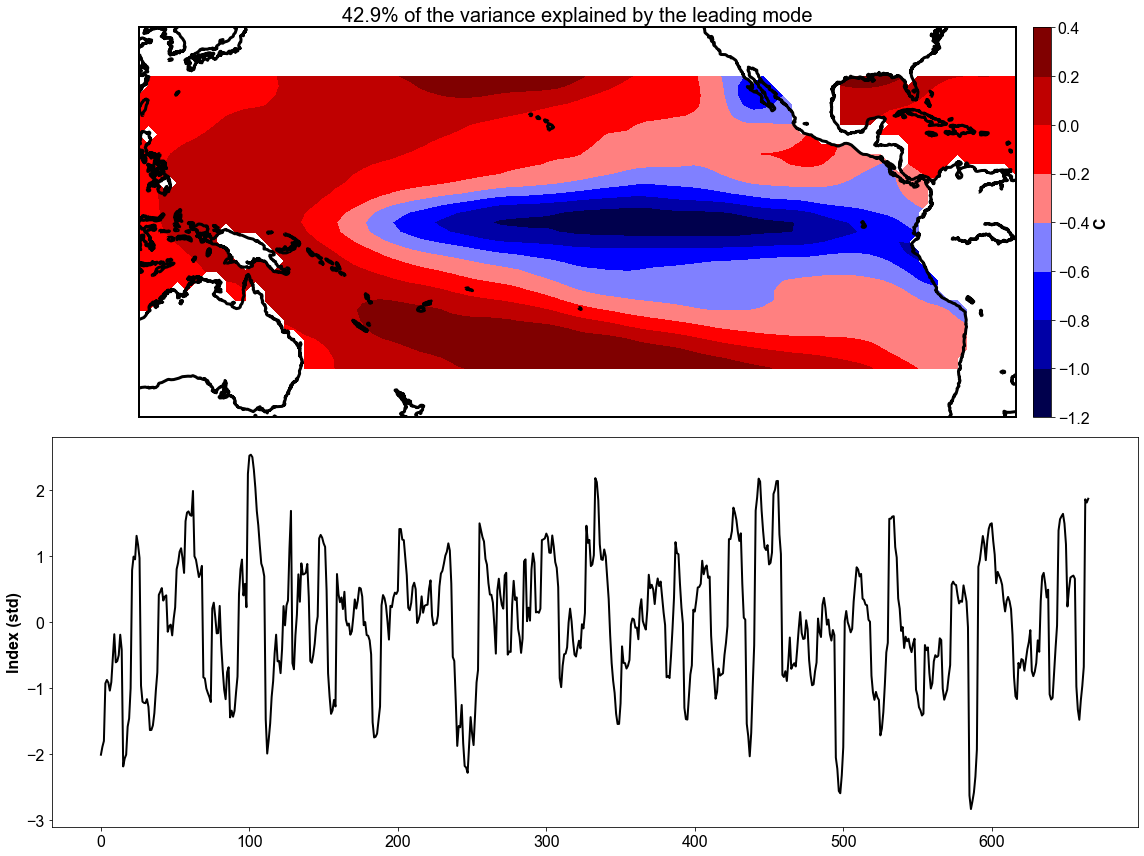

In [64]:
fig= plt.figure(figsize=(16,12))
ax= fig.add_subplot(211)
visualize(lon, lat, regressPatterns[0].reshape(J,I,order='F'), extent=(-120,-60,60,60), ylabel='C')
ax.set_title('%.1f%s of the variance explained by the leading mode'%(varExp[0]*100, str('%')), fontsize=20)
ax= fig.add_subplot(212)
ax.plot( stdPCs[:,0], color='k')
ax.set_ylabel('Index (std)')
plt.tight_layout()

<div class="alert alert-block alert-info" style="font-size:16px">Next, plot the eigenvalue spectrum to check signifiance of the <b>FIRST TEN</b> modes. You will need the effective sample size for the data. For the sample size, we will assume each YEAR is an independent sample. Use the North et al. (1982) significance criterion.</div>

numValues = 10

N = ?
deltaLambda = ?



<div class="alert alert-block alert-info" style="font-size:16px">Make the plot below. You can use the matplotlib error function for the confidence interval. e.g., plt.errorbar(np.arange(1,numValues+1),eigval[:numValues],yerr=deltaLambda,color='r',fmt='o')</div>

plt.figure()